<a href="https://colab.research.google.com/github/Seeeeeyo/CropHarvest/blob/main/Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> IFT-6390 Machine Learning  </h1></center>
<center><h2> Fall - 2021 </h2></center> 
<center><h3> Kaggle competition 2</h3></center> 
<center><h3> </h3></center> 
<center><h3>CropHarvest - crop vs. non-crop</h3></center> 


In [ ]:
pip install comet_ml

In [1]:
import comet_ml
from comet_ml import Experiment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Inspecting Dataset

#### Download the dataset files

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! kaggle competitions download cropharvest-crop-detection

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_nolabels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! unzip test_nolabels.csv.zip
! unzip train.csv.zip

Archive:  test_nolabels.csv.zip
replace test_nolabels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


#### Load the data into DataFrames

In [6]:
df_train = pd.read_csv("train.csv", index_col=0)
df_test = pd.read_csv("test_nolabels.csv", index_col=0) 
df_test.reset_index(drop=True, inplace=True)

#### Get DataFrame info

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62000 entries, 0 to 61999
Columns: 217 entries, S2_B2_jan to LABELS
dtypes: float64(217)
memory usage: 103.1 MB


In [8]:
df_train.head()

,S2_B2_jan,S2_B3_jan,S2_B4_jan,S2_B5_jan,S2_B6_jan,S2_B7_jan,S2_B8_jan,S2_B8A_jan,S2_B9_jan,S2_B11_jan,S2_B12_jan,S1_VV_jan,S1_VH_jan,ERA5_temperature_2m_jan,ERA5_total_precipitation_jan,topo_elevation_jan,topo_slope_jan,NDVI_jan,S2_B2_feb,S2_B3_feb,S2_B4_feb,S2_B5_feb,S2_B6_feb,S2_B7_feb,S2_B8_feb,S2_B8A_feb,S2_B9_feb,S2_B11_feb,S2_B12_feb,S1_VV_feb,S1_VH_feb,ERA5_temperature_2m_feb,ERA5_total_precipitation_feb,topo_elevation_feb,topo_slope_feb,NDVI_feb,S2_B2_mar,S2_B3_mar,S2_B4_mar,S2_B5_mar,...,topo_elevation_oct,topo_slope_oct,NDVI_oct,S2_B2_nov,S2_B3_nov,S2_B4_nov,S2_B5_nov,S2_B6_nov,S2_B7_nov,S2_B8_nov,S2_B8A_nov,S2_B9_nov,S2_B11_nov,S2_B12_nov,S1_VV_nov,S1_VH_nov,ERA5_temperature_2m_nov,ERA5_total_precipitation_nov,topo_elevation_nov,topo_slope_nov,NDVI_nov,S2_B2_dec,S2_B3_dec,S2_B4_dec,S2_B5_dec,S2_B6_dec,S2_B7_dec,S2_B8_dec,S2_B8A_dec,S2_B9_dec,S2_B11_dec,S2_B12_dec,S1_VV_dec,S1_VH_dec,ERA5_temperature_2m_dec,ERA5_total_precipitation_dec,topo_elevation_dec,topo_slope_dec,NDVI_dec,LABELS
0,-14.271277,-21.134172,957.531174,1019.557045,1230.022834,1435.138891,1693.702270,1805.411109,1891.557355,2020.567257,813.448973,2080.473917,1323.079548,281.709319,0.000211,1985.132508,0.889839,0.279574,-15.609204,-25.591754,1328.905608,1159.205172,1455.870367,1862.593978,1794.465460,2440.056316,2384.410237,2666.268567,890.697913,3067.634208,2142.679335,307.780824,-0.000013,1941.930728,1.109999,0.252091,-12.401028,-22.292052,1365.147087,1126.991171,...,2153.114868,0.931598,0.394108,-13.114028,-21.669927,988.092685,932.821140,1134.178887,1359.045039,1789.895844,2361.635270,2176.478381,2584.746245,908.633668,2821.974029,1892.935644,284.421910,-0.000055,1893.625493,1.139009,0.409155,-13.432464,-25.280693,1006.212319,1192.403744,1188.995346,1270.683646,1878.594972,2016.017317,1939.707676,2203.025469,795.862978,2747.777894,1688.997611,289.382220,0.000147,1886.384195,0.749163,0.307887,0.0
1,-12.341429,-14.744978,949.227883,895.845779,987.517322,1350.496916,1930.239804,2048.686546,2375.680146,2259.903290,1094.947052,1946.566875,1222.287890,261.859364,0.003898,106.947249,1.556351,0.385015,-12.132768,-17.236362,1117.105209,817.700059,845.368396,1314.277099,1679.637259,2290.518330,2520.145740,2532.510634,1187.911672,2402.228069,1505.895634,285.216476,0.001642,71.384372,1.721689,0.366103,-12.419310,-17.430682,1115.374275,830.366642,...,105.121547,1.550787,0.440589,-9.905274,-15.177714,1093.831057,808.702515,707.398286,960.143296,1674.463376,2112.860495,2174.426749,2324.012849,1128.248702,1408.210918,825.963181,267.866234,0.002012,56.298678,1.780384,0.421634,-11.457153,-21.862685,2820.559906,2623.351774,2494.619291,2324.743682,2941.385081,2929.446686,2816.650882,2922.382762,1140.796180,2528.590979,1934.261859,266.578370,0.002876,69.876216,1.385904,0.097779,1.0
2,-12.317847,-17.026201,1087.616069,1086.401035,1185.755955,1529.674085,1858.981635,1904.667487,2082.954737,2115.713139,901.358672,2089.401053,1264.965439,268.225405,0.001464,129.077506,2.330955,0.275852,-10.580486,-19.043943,1081.636242,864.645506,647.587432,1263.171837,2111.391293,2940.348843,2909.871161,3069.632334,1203.923188,2166.049964,1149.745776,293.552775,0.002461,93.424621,2.432580,0.440904,-13.189221,-19.967875,1033.570952,729.660783,...,129.252615,2.270394,0.265142,-6.025795,-18.733584,2962.198985,2647.390040,2791.033829,2628.365877,2562.475352,2809.212593,3511.064688,2698.878599,1742.518475,2734.875175,1952.939208,272.628444,0.003630,77.947509,2.525774,-0.029886,-8.543694,-19.620957,1198.922684,1145.868849,789.355634,1016.318463,2352.125830,2482.511759,2425.676203,2548.726966,521.102434,1556.082048,741.212901,276.467873,0.001622,91.279743,2.125908,0.418492,1.0
3,-15.332478,-20.978203,2987.224569,3163.553102,3412.572434,3908.443371,4044.232162,4231.353770,3682.709329,4518.882323,2121.807152,3491.953331,2794.092937,270.616801,0.000489,828.586052,8.927409,0.158648,-16.562082,-25.124176,1813.310348,1869.830367,2342.723821,2973.068745,2963.875853,3895.852592,3773.642543,3985.038188,

In [9]:
df_test.head()

,S2_B2_jan,S2_B3_jan,S2_B4_jan,S2_B5_jan,S2_B6_jan,S2_B7_jan,S2_B8_jan,S2_B8A_jan,S2_B9_jan,S2_B11_jan,S2_B12_jan,S1_VV_jan,S1_VH_jan,ERA5_temperature_2m_jan,ERA5_total_precipitation_jan,topo_elevation_jan,topo_slope_jan,NDVI_jan,S2_B2_feb,S2_B3_feb,S2_B4_feb,S2_B5_feb,S2_B6_feb,S2_B7_feb,S2_B8_feb,S2_B8A_feb,S2_B9_feb,S2_B11_feb,S2_B12_feb,S1_VV_feb,S1_VH_feb,ERA5_temperature_2m_feb,ERA5_total_precipitation_feb,topo_elevation_feb,topo_slope_feb,NDVI_feb,S2_B2_mar,S2_B3_mar,S2_B4_mar,S2_B5_mar,...,ERA5_total_precipitation_oct,topo_elevation_oct,topo_slope_oct,NDVI_oct,S2_B2_nov,S2_B3_nov,S2_B4_nov,S2_B5_nov,S2_B6_nov,S2_B7_nov,S2_B8_nov,S2_B8A_nov,S2_B9_nov,S2_B11_nov,S2_B12_nov,S1_VV_nov,S1_VH_nov,ERA5_temperature_2m_nov,ERA5_total_precipitation_nov,topo_elevation_nov,topo_slope_nov,NDVI_nov,S2_B2_dec,S2_B3_dec,S2_B4_dec,S2_B5_dec,S2_B6_dec,S2_B7_dec,S2_B8_dec,S2_B8A_dec,S2_B9_dec,S2_B11_dec,S2_B12_dec,S1_VV_dec,S1_VH_dec,ERA5_temperature_2m_dec,ERA5_total_precipitation_dec,topo_elevation_dec,topo_slope_dec,NDVI_dec
0,-17.649477,-24.327178,1111.603354,1190.158872,1361.861147,1436.238138,1350.277481,1382.111848,1419.716749,1410.456550,791.939153,1544.845749,954.418168,290.150951,-0.000014,320.552335,0.907441,0.090289,-17.090842,-31.772597,1494.089651,1310.167001,1471.223227,1727.377971,1557.460054,2079.405879,1872.317204,2209.610624,446.378354,2387.852010,1496.711254,318.351112,0.000239,284.120689,1.126154,0.127578,-17.328101,-26.790417,2341.333406,1943.624133,...,0.000057,338.038820,0.947951,0.079908,-16.683532,-26.353509,820.269397,621.081339,574.337359,532.195309,491.053353,556.117036,449.004636,585.462245,909.720871,651.937939,482.306406,292.225523,-0.000129,265.256953,1.155948,-0.118161,-18.158991,-32.178988,955.984617,1071.836061,864.854320,802.212518,929.409800,983.274904,777.782928,966.513644,467.731680,1045.355257,633.790963,296.952437,0.000092,276.466775,0.765980,0.000600
1,-14.559686,-19.936119,1764.795592,1856.603435,2156.740323,2633.317506,2731.894209,2878.742338,2621.323845,3201.553256,653.528138,3813.330232,2619.750610,290.769787,0.000277,228.182568,2.825683,0.224964,-14.098418,-21.872780,1379.575560,1109.498228,1249.058309,1512.309992,1588.693324,2272.925625,2039.929984,2556.545263,279.258159,3360.289686,2261.055792,315.500167,0.003192,192.126606,2.886615,0.239924,-14.720192,-20.933328,1497.123114,1148.047850,...,0.001278,237.317837,2.729996,0.451665,-9.539860,-14.687268,1130.693975,1005.945290,975.491411,1212.845614,1845.339785,2470.270542,2273.930878,2681.168407,624.873649,2374.795765,1423.816872,293.877027,-0.000032,174.896618,3.001843,0.395926,-12.003004,-15.907136,1449.036137,1499.111009,1406.431562,1419.825821,1976.273983,2110.880967,2026.702042,2292.479225,791.909589,2902.059945,1728.924349,298.468523,0.000139,187.130317,2.598537,0.217297
2,-14.208844,-21.404320,1210.320260,1246.028476,1523.531488,1706.652761,2014.364032,2198.544215,2277.422666,2547.302707,493.607303,3180.495470,1993.207870,290.758535,0.000193,370.585959,0.899931,0.279854,-12.988959,-19.602587,1290.396444,1030.335318,1091.917269,1399.452537,1618.089344,2313.608754,2176.693786,2625.514197,259.243765,2788.327927,1602.841871,315.668946,0.001630,333.950817,1.119261,0.278538,-9.789744,-17.073523,1251.713146,1028.116328,...,0.000276,392.596019,0.940974,0.422171,-12.628563,-19.290682,1139.424667,1063.674883,1069.126878,1311.602841,2152.553755,2921.106924,2645.276184,3101.293538,723.809135,2996.171738,1901.663436,293.381766,-0.000124,314.202135,1.148721,0.447757,-11.980708,-20.019002,1425.459868,1529.781735,1454.750721,1473.809798,2082.446821,2214.546398,2103.697056,2369.819453,893.709359,3217.008133,2158.612101,298.045025,0.000104,324.857357,0.758805,0.230539
3,-13.895412,-21.169488,1550.755198,1541.339240,1732.355678,1828.669115,1876.796177,2001.004560,1996.979443,2212.820792,536.626943,2766.871496,1886.968014,290.612265,0.000492,225.296013,1.291606,0.142753,-13.732596,-25.613399,1645.086108,1296.359517,1424.261537,1728.442664,1697.091146,2316

In [10]:
df_train.shape

(62000, 217)

In [11]:
df_test.shape

(1200, 216)

So we have 62000 train data and 1200 test data.
Each consist of 216 features. The labels is the last column in the train set and it's binary.

#### Inspect for null values

In [ ]:
df_train.isnull().sum().sum()

0

In [ ]:
df_test.isnull().sum().sum()

0

#### Visualize the count of crops vs non-crop

In [ ]:
df_train['LABELS'].value_counts()

1.0    41217
0.0    20783
Name: LABELS, dtype: int64

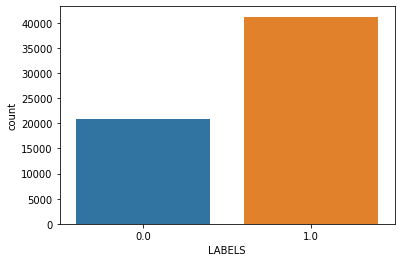

In [ ]:
sns.countplot(x='LABELS', label="Count", data=df_train);

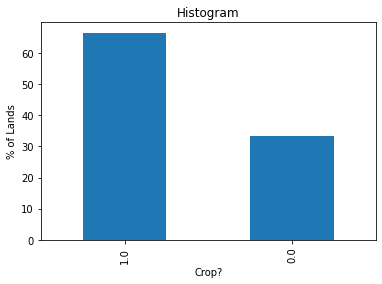

In [ ]:
(df_train["LABELS"].value_counts(normalize=True)*100).plot(kind="bar")
plt.title("Histogram")
plt.ylabel("% of Lands")
plt.xlabel("Crop?")
plt.show();

#### Exploring outliers

#### Remove the duplicates


In [ ]:
remove_duplicates = True
if remove_duplicates:
  len1 = df_train.shape[0]
  df_train = df_train.drop_duplicates() 
  len2 = df_train.shape[0]
  print("There were", (len1-len2), "duplicate rows.")
  print("There is now", len2, "rows in total.")

There were 1894 duplicate rows.
There is now 60106 rows in total.


In [ ]:
remove_duplicates_diff_labels = True
header_x = list(df_train.columns)
header_x.remove('LABELS')
if remove_duplicates_diff_labels:  
  len1 = df_train.shape[0]
  # remove the rows with the same feature values but different labels
  df_train = df_train.drop_duplicates(subset=header_x)
  len2 = df_train.shape[0]
  print("There were", (len1-len2), "rows with the same features values but different labels.")
  print("There is now", len2, "rows in total.")

There were 482 rows with the same features values but different labels.
There is now 59624 rows in total.


#### Dealing with the unbalalance

In [ ]:
undersampling = False
if undersampling:  
  # Let's do undersampling to balance it
  min_num_label = df_train['LABELS'].value_counts().min()
  df_train = df_train.groupby('LABELS').apply(lambda x: x.sample(min_num_label)).reset_index(drop=True)
  df_train.hist(column='LABELS')
  df_train['LABELS'].value_counts()
  # The data is now balanced

In [ ]:
oversampling = False
if oversampling:
  sm = SMOTE()
  X = df_train.drop('LABELS', axis=1)
  y = df_train['LABELS']
  print("X before", X.shape)
  print("y before", y.shape)
  X, y = sm.fit_resample(X, y)
  X = pd.DataFrame(X)
  y = pd.DataFrame(y)
  oversampled = pd.concat([X, y], axis=1)
  print("X after", X.shape)
  print("y after", y.shape)
  oversampled = oversampled.set_axis([*oversampled.columns[:-1], 'LABELS'], axis=1, inplace=False)
  df_train = oversampled
  # The data is now balanced

#### Data Standardization

In [ ]:
# standardization = False
# if standardization:
#   # Standardization of training data
#   for ind in header_x:
#     df_train[ind] = (df_train[ind]-df_train[ind].mean())/df_train[ind].std()

#   # Standardization of test data
#   for ind in header_x:
#     df_test[ind] = (df_test[ind]-df_test[ind].mean())/df_test[ind].std()

# from sklearn.preprocessing import StandardScaler
# # define standard scaler
# scaler = StandardScaler()
# # transform data
# df_train[header_x] = scaler.fit_transform(df_train[header_x])

#### Convert to numpy 

## Pipeline

In [12]:
# split into X and y 
X = df_train.drop(['LABELS'], axis=1)
y = df_train['LABELS']

In [ ]:
# # define the pipeline
# scaler = StandardScaler()
# model = RandomForestClassifier()
# pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
# # evaluate the pipeline
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# n_scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# # report pipeline performance
# print('f1: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#### Split the training data into training and validation set


In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(df_train[header_x], df_train['LABELS'], 
#                                                     test_size=0.3, 
#                                                     shuffle=True, 
#                                                     random_state=76
#                                                     )  

In [ ]:
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

X_train.shape (41736, 216)
X_test.shape (17888, 216)


In [ ]:
# train data (and validation if not simulation)
train_data_np = df_train.to_numpy()

# test data
test_data_np = df_test.to_numpy()

### Models

In [13]:
# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Ensembling
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# Metrics
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [15]:
result = pd.DataFrame(columns = ("Classifiers", "Validation mean f1","Validation std f1"))
classifier, val_mean_scores, val_std_scores = [],[],[]

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import pickle
API_KEY = 'kBRAlsKBa9qYcqfZ3kXA197dW'

#### Test a bunch of algos

In [19]:
models = [
          DecisionTreeClassifier(), 
          # LogisticRegression(), 
          KNeighborsClassifier(), 
          SVC(),
          SVC(kernel='rbf', degree=3), 
          # Perceptron(), 
          RandomForestClassifier(),
          AdaBoostClassifier()
          ]
models_name = [
               "DecisionTreeClassifier", 
              #  "LogisticRegression", 
               "KNeighborsClassifier_5", 
               "SVMClassifier_degree_1", 
               "SVMClassifier_degree_3", 
              #  "PerceptronClassifier", 
               "RandomForestClassifier",
               "AdaBoostClassifier"
               ]

for i in range(len(models)):
  n_scores = 0
  # create an experiment in comet 
  experiment = Experiment(
      api_key=API_KEY,
      project_name="crop-harvest",
      workspace="selimgilon")
  # get the model name
  model_name = models_name[i]
  # set the name of the experiment 
  experiment.set_name(model_name)  
  # used for tracking the simulation   
  print("model:", model_name)
  model = models[i]
  # define the pipeline
  scaler = StandardScaler()
  pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
  # evaluate the pipeline
  cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
  n_scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
  # report pipeline performance
  mean_f1 = np.mean(n_scores)
  std_f1 = np.std(n_scores)
  classifier.append(model_name)
  val_mean_scores.append(mean_f1)
  val_std_scores.append(std_f1)
  print('f1___ mean: %.3f___std:(%.3f)' % (mean_f1, std_f1))
  # dump the model 
  with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
  # log the model 
  experiment.log_model(model_name, "model.pkl")
  experiment.add_tags([model_name])
  experiment.log_metric("val_mean_f1", mean_f1)
  experiment.log_metric("val__std_f1", std_f1)
  experiment.log_parameters({"model": ""})
  experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/selimgilon/crop-harvest/c5627e4a8c26463e881cfb59b2a3b37b



model: DecisionTreeClassifier
f1___ mean: 0.827___std:(0.003)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/selimgilon/crop-harvest/c5627e4a8c26463e881cfb59b2a3b37b
COMET INFO:   Metrics:
COMET INFO:     val__std_f1 : 0.00284216788437024
COMET INFO:     val_mean_f1 : 0.8272341825458099
COMET INFO:   Others:
COMET INFO:     Name         : DecisionTreeClassifier
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FSeeeeeyo%2FCropHarvest%2Fblob%2Fmain%2FClassifiers.ipynb
COMET INFO:   Parameters:
COMET INFO:     model : 
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (401 bytes)
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:

model: KNeighborsClassifier_5


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



f1___ mean: 0.859___std:(0.002)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/selimgilon/crop-harvest/387d33218c8d411d9455c3c5a8a6f4af
COMET INFO:   Metrics:
COMET INFO:     val__std_f1 : 0.001952444250142239
COMET INFO:     val_mean_f1 : 0.858727108850867
COMET INFO:   Others:
COMET INFO:     Name         : KNeighborsClassifier_5
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FSeeeeeyo%2FCropHarvest%2Fblob%2Fmain%2FClassifiers.ipynb
COMET INFO:   Parameters:
COMET INFO:     model : 
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (287 bytes)
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:

model: SVMClassifier_degree_1
f1___ mean: 0.875___std:(0.002)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/selimgilon/crop-harvest/921cf79c1b844ca7a18bb6f42f910f8c
COMET INFO:   Metrics:
COMET INFO:     val__std_f1 : 0.00225860440562866
COMET INFO:     val_mean_f1 : 0.8747433615132901
COMET INFO:   Others:
COMET INFO:     Name         : SVMClassifier_degree_1
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FSeeeeeyo%2FCropHarvest%2Fblob%2Fmain%2FClassifiers.ipynb
COMET INFO:   Parameters:
COMET INFO:     model : 
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (424 bytes)
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:

model: SVMClassifier_degree_3
f1___ mean: 0.875___std:(0.002)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/selimgilon/crop-harvest/2581374d202c44e093007f6e176e43b1
COMET INFO:   Metrics:
COMET INFO:     val__std_f1 : 0.00225860440562866
COMET INFO:     val_mean_f1 : 0.8747433615132901
COMET INFO:   Others:
COMET INFO:     Name         : SVMClassifier_degree_3
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FSeeeeeyo%2FCropHarvest%2Fblob%2Fmain%2FClassifiers.ipynb
COMET INFO:   Parameters:
COMET INFO:     model : 
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (424 bytes)
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:

model: RandomForestClassifier
f1___ mean: 0.883___std:(0.002)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/selimgilon/crop-harvest/3c13492cb044438a8e52f588dc3fa846
COMET INFO:   Metrics:
COMET INFO:     val__std_f1 : 0.0016090008613193708
COMET INFO:     val_mean_f1 : 0.8832522353028159
COMET INFO:   Others:
COMET INFO:     Name         : RandomForestClassifier
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FSeeeeeyo%2FCropHarvest%2Fblob%2Fmain%2FClassifiers.ipynb
COMET INFO:   Parameters:
COMET INFO:     model : 
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (726 bytes)
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INF

model: AdaBoostClassifier
f1___ mean: 0.835___std:(0.003)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/selimgilon/crop-harvest/e7f3399af5a14819bd64690d3f78da76
COMET INFO:   Metrics:
COMET INFO:     val__std_f1 : 0.002785034734070117
COMET INFO:     val_mean_f1 : 0.835001872152838
COMET INFO:   Others:
COMET INFO:     Name         : AdaBoostClassifier
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FSeeeeeyo%2FCropHarvest%2Fblob%2Fmain%2FClassifiers.ipynb
COMET INFO:   Parameters:
COMET INFO:     model : 
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (250 bytes)
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:    

In [26]:
for i, text in enumerate(classifier):
    result.loc[i+1] = [text,np.around(val_mean_scores[i]*100, decimals = 1),np.around(val_std_scores[i], decimals=4)]
result

,Classifiers,Validation mean f1,Validation std f1
1,AdaBoostClassifier,83.2,0.0014
2,DecisionTreeClassifier,82.7,0.0028
3,KNeighborsClassifier_5,85.9,0.0020
4,SVMClassifier_degree_1,87.5,0.0023
5,SVMClassifier_degree_3,87.5,0.0023
6,RandomForestClassifier,88.3,0.0016
7,AdaBoostClassifier,83.5,0.0028


In [34]:
df_test.head()

,S2_B2_jan,S2_B3_jan,S2_B4_jan,S2_B5_jan,S2_B6_jan,S2_B7_jan,S2_B8_jan,S2_B8A_jan,S2_B9_jan,S2_B11_jan,S2_B12_jan,S1_VV_jan,S1_VH_jan,ERA5_temperature_2m_jan,ERA5_total_precipitation_jan,topo_elevation_jan,topo_slope_jan,NDVI_jan,S2_B2_feb,S2_B3_feb,S2_B4_feb,S2_B5_feb,S2_B6_feb,S2_B7_feb,S2_B8_feb,S2_B8A_feb,S2_B9_feb,S2_B11_feb,S2_B12_feb,S1_VV_feb,S1_VH_feb,ERA5_temperature_2m_feb,ERA5_total_precipitation_feb,topo_elevation_feb,topo_slope_feb,NDVI_feb,S2_B2_mar,S2_B3_mar,S2_B4_mar,S2_B5_mar,...,ERA5_total_precipitation_oct,topo_elevation_oct,topo_slope_oct,NDVI_oct,S2_B2_nov,S2_B3_nov,S2_B4_nov,S2_B5_nov,S2_B6_nov,S2_B7_nov,S2_B8_nov,S2_B8A_nov,S2_B9_nov,S2_B11_nov,S2_B12_nov,S1_VV_nov,S1_VH_nov,ERA5_temperature_2m_nov,ERA5_total_precipitation_nov,topo_elevation_nov,topo_slope_nov,NDVI_nov,S2_B2_dec,S2_B3_dec,S2_B4_dec,S2_B5_dec,S2_B6_dec,S2_B7_dec,S2_B8_dec,S2_B8A_dec,S2_B9_dec,S2_B11_dec,S2_B12_dec,S1_VV_dec,S1_VH_dec,ERA5_temperature_2m_dec,ERA5_total_precipitation_dec,topo_elevation_dec,topo_slope_dec,NDVI_dec
0,-17.649477,-24.327178,1111.603354,1190.158872,1361.861147,1436.238138,1350.277481,1382.111848,1419.716749,1410.456550,791.939153,1544.845749,954.418168,290.150951,-0.000014,320.552335,0.907441,0.090289,-17.090842,-31.772597,1494.089651,1310.167001,1471.223227,1727.377971,1557.460054,2079.405879,1872.317204,2209.610624,446.378354,2387.852010,1496.711254,318.351112,0.000239,284.120689,1.126154,0.127578,-17.328101,-26.790417,2341.333406,1943.624133,...,0.000057,338.038820,0.947951,0.079908,-16.683532,-26.353509,820.269397,621.081339,574.337359,532.195309,491.053353,556.117036,449.004636,585.462245,909.720871,651.937939,482.306406,292.225523,-0.000129,265.256953,1.155948,-0.118161,-18.158991,-32.178988,955.984617,1071.836061,864.854320,802.212518,929.409800,983.274904,777.782928,966.513644,467.731680,1045.355257,633.790963,296.952437,0.000092,276.466775,0.765980,0.000600
1,-14.559686,-19.936119,1764.795592,1856.603435,2156.740323,2633.317506,2731.894209,2878.742338,2621.323845,3201.553256,653.528138,3813.330232,2619.750610,290.769787,0.000277,228.182568,2.825683,0.224964,-14.098418,-21.872780,1379.575560,1109.498228,1249.058309,1512.309992,1588.693324,2272.925625,2039.929984,2556.545263,279.258159,3360.289686,2261.055792,315.500167,0.003192,192.126606,2.886615,0.239924,-14.720192,-20.933328,1497.123114,1148.047850,...,0.001278,237.317837,2.729996,0.451665,-9.539860,-14.687268,1130.693975,1005.945290,975.491411,1212.845614,1845.339785,2470.270542,2273.930878,2681.168407,624.873649,2374.795765,1423.816872,293.877027,-0.000032,174.896618,3.001843,0.395926,-12.003004,-15.907136,1449.036137,1499.111009,1406.431562,1419.825821,1976.273983,2110.880967,2026.702042,2292.479225,791.909589,2902.059945,1728.924349,298.468523,0.000139,187.130317,2.598537,0.217297
2,-14.208844,-21.404320,1210.320260,1246.028476,1523.531488,1706.652761,2014.364032,2198.544215,2277.422666,2547.302707,493.607303,3180.495470,1993.207870,290.758535,0.000193,370.585959,0.899931,0.279854,-12.988959,-19.602587,1290.396444,1030.335318,1091.917269,1399.452537,1618.089344,2313.608754,2176.693786,2625.514197,259.243765,2788.327927,1602.841871,315.668946,0.001630,333.950817,1.119261,0.278538,-9.789744,-17.073523,1251.713146,1028.116328,...,0.000276,392.596019,0.940974,0.422171,-12.628563,-19.290682,1139.424667,1063.674883,1069.126878,1311.602841,2152.553755,2921.106924,2645.276184,3101.293538,723.809135,2996.171738,1901.663436,293.381766,-0.000124,314.202135,1.148721,0.447757,-11.980708,-20.019002,1425.459868,1529.781735,1454.750721,1473.809798,2082.446821,2214.546398,2103.697056,2369.819453,893.709359,3217.008133,2158.612101,298.045025,0.000104,324.857357,0.758805,0.230539
3,-13.895412,-21.169488,1550.755198,1541.339240,1732.355678,1828.669115,1876.796177,2001.004560,1996.979443,2212.820792,536.626943,2766.871496,1886.968014,290.612265,0.000492,225.296013,1.291606,0.142753,-13.732596,-25.613399,1645.086108,1296.359517,1424.261537,1728.442664,1697.091146,2316

In [36]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
df_test_scaled = scaler.transform(df_test)

In [43]:
model_name = 'sub3_KNN'

# create an experiment in comet 
experiment = Experiment(
    api_key=API_KEY,
    project_name="crop-harvest",
    workspace="selimgilon")

# set the name of the experiment 
experiment.set_name(model_name)  

# create and fit a model
model = KNeighborsClassifier()
model.fit(X, y)

pred = pd.DataFrame()
pred["LABELS"] = model.predict(df_test_scaled)
pred.index.name = 'S.No'
pred.reset_index(inplace=True)
pred.LABELS = pred.LABELS.astype(int)
pred.head()
pred.to_csv("submission3.csv", sep=',' ,index=False)


# dump the model 
with open('model.pkl', 'wb') as f:
  pickle.dump(model, f)
# log the model 
experiment.log_model(model_name, "model.pkl")
experiment.add_tags([model_name])
experiment.log_parameters({"model": ""})
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/selimgilon/crop-harvest/a8d7fff12acd41e4b56821fef806d848
COMET INFO:   Others:
COMET INFO:     Name         : sub3_SVM
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FSeeeeeyo%2FCropHarvest%2Fblob%2Fmain%2FClassifiers.ipynb
COMET INFO:   Parameters:
COMET INFO:     C                       : 1.0
COMET INFO:     break_ties              : False
COMET INFO:     cache_size              : 200
COMET INFO:     class_weight            : 1
COMET INFO:     coef0                   : 0.0
COMET INFO:     decision_function_shape : ovr
COMET INFO:     degree                  : 3
COMET INFO:     gamma                   : scale
COMET INFO:     kernel                  : rbf
COMET INFO:     max_iter         

------------------------------------------------------

#### Initialization

#### Decision Tree

In [ ]:
clf_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    # class_weight="balanced",\
    # min_weight_fraction_leaf=0.01\
    )
clf_tree = clf_tree.fit(X_train,y_train)
classifier.append("DecisionTreeClassifier")
train_scores.append(clf_tree.f1_score(X_train, y_train))
test_scores.append(clf_tree.f1_score(X_test, y_test))

#### Logistic Regression

In [ ]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X_train,y_train)
classifier.append("LogisticRegression")
train_scores.append(clf_log.f1_score(X_train, y_train))
test_scores.append(clf_log.f1_score(X_test, y_test))

# pd.DataFrame(list(zip(X_train.columns, np.transpose(clf_log.coef_))))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
classifier.append("KNeighborsClassifier")
train_scores.append(knn.score(X_train, y_train))
test_scores.append(knn.score(X_test, y_test))

#### Support Vector Classifier

In [ ]:
cf = SVC()
cf.fit(X_train, y_train)
classifier.append("SVM")
train_scores.append(cf.score(X_train, y_train))
test_scores.append(cf.score(X_test, y_test))

#### Perceptron

In [ ]:
clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X_train,y_train)
classifier.append("Perceptron")
train_scores.append(clf_pctr.score(X_train, y_train))
test_scores.append(clf_pctr.score(X_test, y_test))

#### Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
classifier.append("RandomForestClassifier")
train_scores.append(random_forest.score(X_train, y_train))
test_scores.append(random_forest.score(X_test, y_test))

#### Extra Tree 

In [ ]:
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
clf_ext = clf_ext.fit(X_train,y_train)
classifier.append("ExtraTreesClassifier")
train_scores.append(clf_ext.score(X_train, y_train))
test_scores.append(clf_ext.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"


#### Ada Boost

In [ ]:
clf_ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
clf_ada.fit(X_train,y_train)
classifier.append("AdaBoostClassifier")
train_scores.append(clf_ada.score(X_train, y_train))
test_scores.append(clf_ada.score(X_test, y_test))

#### Results

In [ ]:
for i,text in enumerate(classifier):
    result.loc[i+1] = [text,np.around(train_scores[i]*100, decimals = 1),np.around(test_scores[i]*100, decimals=1)]
result

,Classifiers,Training,Testing
1,DecisionTreeClassifier,75.1,74.4
2,LogisticRegression,73.1,73.0
3,KNeighborsClassifier,88.0,77.6
4,SVM,79.2,77.8
5,Perceptron,46.9,46.4
6,RandomForestClassifier,100.0,85.0
7,ExtraTreesClassifier,97.7,84.1
8,AdaBoostClassifier,78.7,78.8


# Ensemble Methods

In [ ]:
# Trying to improve with the ensemble of all predictors

clf_vote = VotingClassifier(
    estimators=[
        ('knn', knn), # KNN
        ('svm', cf), # SVM
        ('dt', clf_tree), # Decision Tree
        ('extra', clf_ext), #  Extra Tree
        ('logistic', clf_log), # Logistic Regression
        ('adaboost', clf_ada) # Adaboost
        ],
    weights=[1, 1, 1, 1, 1, 1],
    voting='hard')
clf_vote.fit(X_train, y_train)
clf_vote.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8172517889087657

# Cross Validation

In [ ]:
scores = cross_val_score(clf_vote, df_train[header_x], df_train['LABELS'], cv=5, scoring='f1')
print("Voting: f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


KeyboardInterrupt: ignored

-------------------------------------------------

# Submission File

In [ ]:
clf_vote.fit(df_train[header_x], df_train['LABELS'])
y_pred = clf_vote.predict(df_test[header_x])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
df_test.head()

,S2_B2_jan,S2_B3_jan,S2_B4_jan,S2_B5_jan,S2_B6_jan,S2_B7_jan,S2_B8_jan,S2_B8A_jan,S2_B9_jan,S2_B11_jan,S2_B12_jan,S1_VV_jan,S1_VH_jan,ERA5_temperature_2m_jan,ERA5_total_precipitation_jan,topo_elevation_jan,topo_slope_jan,NDVI_jan,S2_B2_feb,S2_B3_feb,S2_B4_feb,S2_B5_feb,S2_B6_feb,S2_B7_feb,S2_B8_feb,S2_B8A_feb,S2_B9_feb,S2_B11_feb,S2_B12_feb,S1_VV_feb,S1_VH_feb,ERA5_temperature_2m_feb,ERA5_total_precipitation_feb,topo_elevation_feb,topo_slope_feb,NDVI_feb,S2_B2_mar,S2_B3_mar,S2_B4_mar,S2_B5_mar,...,ERA5_total_precipitation_oct,topo_elevation_oct,topo_slope_oct,NDVI_oct,S2_B2_nov,S2_B3_nov,S2_B4_nov,S2_B5_nov,S2_B6_nov,S2_B7_nov,S2_B8_nov,S2_B8A_nov,S2_B9_nov,S2_B11_nov,S2_B12_nov,S1_VV_nov,S1_VH_nov,ERA5_temperature_2m_nov,ERA5_total_precipitation_nov,topo_elevation_nov,topo_slope_nov,NDVI_nov,S2_B2_dec,S2_B3_dec,S2_B4_dec,S2_B5_dec,S2_B6_dec,S2_B7_dec,S2_B8_dec,S2_B8A_dec,S2_B9_dec,S2_B11_dec,S2_B12_dec,S1_VV_dec,S1_VH_dec,ERA5_temperature_2m_dec,ERA5_total_precipitation_dec,topo_elevation_dec,topo_slope_dec,NDVI_dec
0,-17.649477,-24.327178,1111.603354,1190.158872,1361.861147,1436.238138,1350.277481,1382.111848,1419.716749,1410.456550,791.939153,1544.845749,954.418168,290.150951,-0.000014,320.552335,0.907441,0.090289,-17.090842,-31.772597,1494.089651,1310.167001,1471.223227,1727.377971,1557.460054,2079.405879,1872.317204,2209.610624,446.378354,2387.852010,1496.711254,318.351112,0.000239,284.120689,1.126154,0.127578,-17.328101,-26.790417,2341.333406,1943.624133,...,0.000057,338.038820,0.947951,0.079908,-16.683532,-26.353509,820.269397,621.081339,574.337359,532.195309,491.053353,556.117036,449.004636,585.462245,909.720871,651.937939,482.306406,292.225523,-0.000129,265.256953,1.155948,-0.118161,-18.158991,-32.178988,955.984617,1071.836061,864.854320,802.212518,929.409800,983.274904,777.782928,966.513644,467.731680,1045.355257,633.790963,296.952437,0.000092,276.466775,0.765980,0.000600
1,-14.559686,-19.936119,1764.795592,1856.603435,2156.740323,2633.317506,2731.894209,2878.742338,2621.323845,3201.553256,653.528138,3813.330232,2619.750610,290.769787,0.000277,228.182568,2.825683,0.224964,-14.098418,-21.872780,1379.575560,1109.498228,1249.058309,1512.309992,1588.693324,2272.925625,2039.929984,2556.545263,279.258159,3360.289686,2261.055792,315.500167,0.003192,192.126606,2.886615,0.239924,-14.720192,-20.933328,1497.123114,1148.047850,...,0.001278,237.317837,2.729996,0.451665,-9.539860,-14.687268,1130.693975,1005.945290,975.491411,1212.845614,1845.339785,2470.270542,2273.930878,2681.168407,624.873649,2374.795765,1423.816872,293.877027,-0.000032,174.896618,3.001843,0.395926,-12.003004,-15.907136,1449.036137,1499.111009,1406.431562,1419.825821,1976.273983,2110.880967,2026.702042,2292.479225,791.909589,2902.059945,1728.924349,298.468523,0.000139,187.130317,2.598537,0.217297
2,-14.208844,-21.404320,1210.320260,1246.028476,1523.531488,1706.652761,2014.364032,2198.544215,2277.422666,2547.302707,493.607303,3180.495470,1993.207870,290.758535,0.000193,370.585959,0.899931,0.279854,-12.988959,-19.602587,1290.396444,1030.335318,1091.917269,1399.452537,1618.089344,2313.608754,2176.693786,2625.514197,259.243765,2788.327927,1602.841871,315.668946,0.001630,333.950817,1.119261,0.278538,-9.789744,-17.073523,1251.713146,1028.116328,...,0.000276,392.596019,0.940974,0.422171,-12.628563,-19.290682,1139.424667,1063.674883,1069.126878,1311.602841,2152.553755,2921.106924,2645.276184,3101.293538,723.809135,2996.171738,1901.663436,293.381766,-0.000124,314.202135,1.148721,0.447757,-11.980708,-20.019002,1425.459868,1529.781735,1454.750721,1473.809798,2082.446821,2214.546398,2103.697056,2369.819453,893.709359,3217.008133,2158.612101,298.045025,0.000104,324.857357,0.758805,0.230539
3,-13.895412,-21.169488,1550.755198,1541.339240,1732.355678,1828.669115,1876.796177,2001.004560,1996.979443,2212.820792,536.626943,2766.871496,1886.968014,290.612265,0.000492,225.296013,1.291606,0.142753,-13.732596,-25.613399,1645.086108,1296.359517,1424.261537,1728.442664,1697.091146,2316

In [ ]:
dummy = pd.DataFrame()
dummy["LABELS"]=clf_vote.predict(df_test[header_x])

In [ ]:
dummy.index.name = 'S.No'
dummy.reset_index(inplace=True)

ValueError: ignored

In [ ]:
dummy.LABELS = dummy.LABELS.astype(int)
dummy.head()

ValueError: ignored

In [ ]:
dummy.to_csv("submission.csv", sep=',' ,index=False)

In [ ]:
submit = False
if submit:
  kaggle competitions submit -c cropharvest-crop-detection -f submission.csv -m "1st"

SyntaxError: ignored

This submission file gives an accuracy of ... % at https://www.kaggle.com/c/cropharvest-crop-detection/submit

-------------------------------------------------------------------------

### Neural Network

In [ ]:
# !nvidia-smi
# !pip install "wheel==0.34.2"
# !pip install "scikit-learn==0.21.2"
# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
# import torch
# %pylab inline
# print(torch.__version__)
# device = torch.device('cuda:0') # we use 0 to specify the first GPU
accelerator

In [ ]:
!pip install keras

In [ ]:
import keras

In [ ]:
keras.backend.backend()

In [ ]:
# Prepare the dataset
num_features = X_train.shape[1]
num_features

In [ ]:
# define and fit the model
def get_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(100, input_dim = trainX.shape, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=300, verbose=0)
	return model

In [ ]:
# model creation
# Define model
model = Sequential()
model.add(Dense(1, activation='linear', input_shape=(num_features,)))

# View model
model.summary()